# Constructing the Pipelines and training the models
## Scoring metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
files = '../files'

# Read data
data = pd.read_csv(f'{files}/data.csv')
activity_label = 'f_activity'

# Read descriptors
descriptors = pd.read_csv(f'{files}/descriptors.csv.gz', compression='gzip')

# Descriptors
descriptors_list = ['NumAliphaticCarbocycles', 'TPSA', 'fr_urea', 'NumHDonors', 'fr_NH2', 'NumHAcceptors']
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']
trainset = descriptors_list + docking_list

# Test metrics
scoring_metrics = ['test_accuracy','test_precision','test_recall','test_f1','test_f2',
                   'test_geometric_mean','test_roc_auc']
columns = ['activity_label', 'model', 'random_state', scoring_metrics] + trainset

# ML classfifiers
model_list = ['LogisticRegression','RandomForestClassifier','KNeighborsClassifier',
        'LinearSVC','XGBClassifier', 'DecisionTreeClassifier']

<a id='hyperparameters'></a>
## Fine-tuning hyperparameters

In [3]:
def get_model_and_params(model_name, nsamples):
    if model_name == 'KNeighborsClassifier':
        from sklearn.neighbors import KNeighborsClassifier
        model = KNeighborsClassifier()
        params = {'clf__n_neighbors': [3, 5, 7, int(np.sqrt(nsamples))]}
    elif model_name == 'XGBClassifier':
        from xgboost import XGBClassifier
        model = XGBClassifier(random_state=13)
        params = {'clf__n_estimators': [40, 100, 200, 500, 1000], 
                 'clf__max_depth': [3, 4, 5, 6, 7, 8, 10, None], 
                 'clf__eta': [0.1, 0.2, 0.3]}
    elif model_name == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(random_state=13)
        params = {'clf__n_estimators': [40, 100, 200, 500, 1000], 
                 'clf__max_depth': [3, 4, 5, 6, 7, 8, 10, None]}

    else:
        from sklearn.tree import DecisionTreeClassifier
        model = DecisionTreeClassifier(random_state=13)
        params = {'clf__max_depth': [3, 4, 5, 6, 7, 8, 10, None]}
        
    return model, params

def grid_search(model, X, y, transformer, param_grid):
    from imblearn.pipeline import Pipeline
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.model_selection import GridSearchCV
    
    pipe = Pipeline(steps=[('smote', SMOTE(random_state=42)), ('transformer', transformer), ('clf', model)])
    grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=RepeatedStratifiedKFold(n_splits=10), 
                        scoring='roc_auc', n_jobs=-1)
    grid.fit(X, y)
    return grid
    
def grid_data(grid, model_name):
    results = []
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        test_score = {'clf': model_name, 'mean_test_score': mean, 'std_test_score': std}
        results.append({**test_score, **params}) # Concatenate two dicts
    
    return pd.DataFrame(results)

def get_grid_df(data, classifiers, descriptors_list, activity_label, transformer):
    grid_df = pd.DataFrame()

    X = data[descriptors_list]
    y = data[activity_label]
    
    for clf in classifiers:
        model, param_grid = get_model_and_params(clf, len(X))
        grid = grid_search(model, X, y, transformer, param_grid)
        print(f'{model_name:<22s} {grid.best_params_}')

        tmp = grid_data(grid, model_name)
        grid_df = pd.concat([grid_df, tmp], axis=0, join='outer')

    grid_df.reset_index(drop=True, inplace=True)
    grid_df.to_csv('grid_search3.csv', index=False)
    return grid_df

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
    
continuous = ['float16', 'float32', 'float64']
discrete = ['int16', 'int32', 'int64']

transformer = ColumnTransformer(transformers=[
    ('continuous', StandardScaler(), data[subset].select_dtypes(include=continuous).columns.tolist()), 
    ('discrete', OneHotEncoder(handle_unknown='ignore'), data[subset].select_dtypes(include=discrete).columns.tolist())
])

classifiers = ['RandomForestClassifier','KNeighborsClassifier','XGBClassifier','DecisionTreeClassifier']
grid_df = get_grid_df(data, classifiers, descriptors_list, activity_label, transformer)

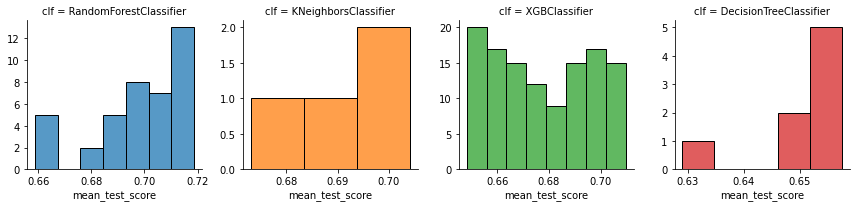

In [6]:
g = sns.FacetGrid(data=grid_df, hue='clf', col='clf', sharex=False, sharey=False)
g.map(sns.histplot,'mean_test_score')

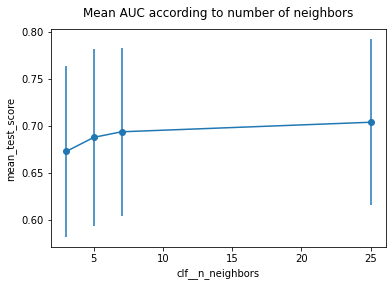

In [13]:
grid_knn = grid_df.query('clf == "KNeighborsClassifier"')
x = grid_knn['clf__n_neighbors']
y = grid_knn['mean_test_score']
plt.errorbar(x, y, yerr=grid_knn['std_test_score'], marker='o')
plt.xlabel('clf__n_neighbors')
plt.ylabel('mean_test_score')
plt.title('KNeighborsClassifier')
plt.title('Mean AUC according to number of neighbors', y=1.03)
plt.show()

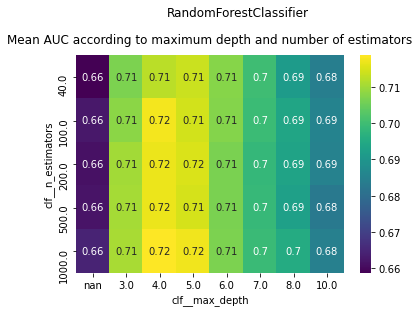

In [17]:
grid_rf = grid_df.query('clf == "RandomForestClassifier"')

table = grid_rf.pivot('clf__n_estimators', 'clf__max_depth', 'mean_test_score')
sns.heatmap(table, cmap='viridis', annot=True)
plt.suptitle('RandomForestClassifier', y=1.05)
plt.title('Mean AUC according to maximum depth and number of estimators', y=1.03)
plt.show()

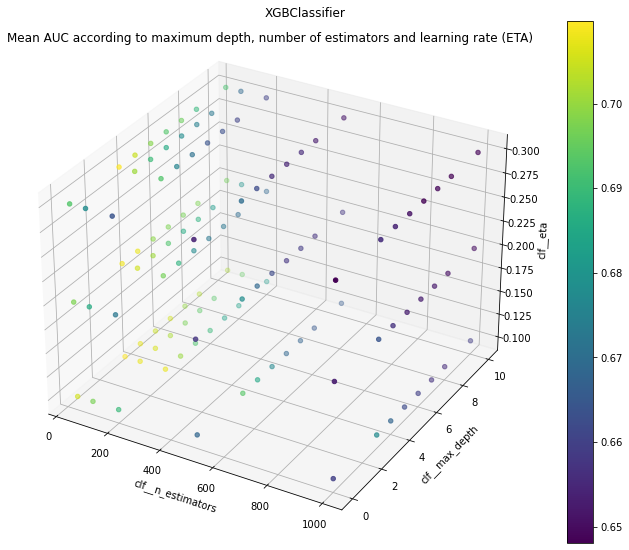

In [18]:
grid_xgb = grid_df.query('clf == "XGBClassifier"')
grid_xgb = grid_xgb.fillna(value=0)

x = grid_xgb['clf__n_estimators']
y = grid_xgb['clf__max_depth']
z = grid_xgb['clf__eta']
c = grid_xgb['mean_test_score']

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12.8, 9.6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x, y, z, c=c, cmap='viridis')
fig.colorbar(p)

ax.set_xlabel('clf__n_estimators')
ax.set_ylabel('clf__max_depth')
ax.set_zlabel('clf__eta')
plt.suptitle('XGBClassifier', y=0.9)
plt.title('Mean AUC according to maximum depth, number of estimators and learning rate (ETA)', y=1.03)
plt.show()

<a id='reconstructing'></a>
## Reconstructing the top models

In [4]:
def get_model_opt_by_name(model_name):
    if model_name == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(n_estimators=1000, max_depth=4, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        from sklearn.neighbors import KNeighborsClassifier
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'XGBClassifier':
        from xgboost import XGBClassifier
        return XGBClassifier(objective='binary:logistic', n_estimators=200, 
            max_depth=3, eta=0.3, random_state=13)
    elif model_name == 'DecisionTreeClassifier':
        from sklearn.tree import DecisionTreeClassifier
        return DecisionTreeClassifier(max_depth=8, random_state=13)
    elif model_name == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        from sklearn.svm import LinearSVC
        from sklearn.calibration import CalibratedClassifierCV
        # CalibratedClassifierCV is used for applying probability transformation 
        # on top of the SVC outputs, so we can plot the ROC curve
        # https://stackoverflow.com/a/39712590/13131079
        return CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, random_state=13))
    else:
        return None

In [112]:
def train_test_scores(X_train, X_test, y_train, y_test, model_fitted):
    from sklearn.metrics import fbeta_score
    from imblearn.metrics import geometric_mean_score
    
    scores_list = []
    y_pred_test = model_fitted.predict(X_test)
    y_pred_train = model_fitted.predict(X_train)
    
    scores_list.append(fbeta_score(y_test, y_pred_test, beta=2))       # test_f2
    scores_list.append(fbeta_score(y_train, y_pred_train, beta=2))     # train_f2
    scores_list.append(geometric_mean_score(y_test, y_pred_test))      # test_geometric_mean
    scores_list.append(geometric_mean_score(y_train, y_pred_train))    # train_geometric_mean
    return scores_list

def get_tpr_KFold(X, y, model_fitted, base_fpr):
    from sklearn.metrics import roc_curve
    
    y_proba = model_fitted.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, y_proba[:,1])
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    return tpr

def plot_train_test_roc(axis, tpr_test_list, tpr_train_list, base_fpr, model_name):
    from sklearn.metrics import auc
    # Test mean ROC
    tpr_test = np.mean(tpr_test_list, axis=0)
    tpr_test[-1] = 1.0
    test_auc = auc(base_fpr, tpr_test)
    axis[0].plot(base_fpr, tpr_test, label=model_name)

    # Training mean ROC
    tpr_train = np.mean(tpr_train_list, axis=0)
    tpr_train[-1] = 1.0
    train_auc = auc(base_fpr, tpr_train)
    axis[1].plot(base_fpr, tpr_train, label=model_name)
    
    return test_auc, train_auc

def get_scores_list_KFold(X, y, pipe, base_fpr):
    from sklearn.model_selection import RepeatedStratifiedKFold
    
    scores_list_KFold = []
    tpr_train_list = []
    tpr_test_list = []
    
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=5)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        model_fitted = pipe.fit(X_train, y_train)
        # Test and training scores
        scores_list_KFold.append(train_test_scores(X_train, X_test, y_train, y_test, model_fitted))
        # Test true positive rate
        tpr_test_list.append(get_tpr_KFold(X_test, y_test, model_fitted, base_fpr))
        # Training true positive rate
        tpr_train_list.append(get_tpr_KFold(X_train, y_train, model_fitted, base_fpr))
    
    return scores_list_KFold, tpr_train_list, tpr_test_list
    
def get_mean_scores(X, y, model, model_name, transformer, axis):
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import make_pipeline
    
    base_fpr = np.linspace(0, 1, 101)
    pipe = make_pipeline(SMOTE(random_state=42), transformer, model)
    scores_list_KFold, tpr_train_list, tpr_test_list = get_scores_list_KFold(X, y, pipe, base_fpr)
    
    # All KFold scores for each metric
    df = pd.DataFrame(scores_list_KFold)
    # Mean of the KFold scores by metric
    mean_scores = list(df.mean()) # column-wise
    
    # Plot mean ROC curve
    test_auc, train_auc = plot_train_test_roc(axis, tpr_test_list, tpr_train_list, base_fpr, model_name)
    # Append mean AUC
    mean_scores.append(test_auc)
    mean_scores.append(train_auc)
    mean_scores.append(model_name)
    return mean_scores

<a id='roc_curves'></a>
### ROC curves

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

y = data[activity_label]
X = data[descriptors_list]

continuous = ['float16', 'float32', 'float64']
discrete = ['int16', 'int32', 'int64']

transformer = ColumnTransformer(transformers=[
    ('continuous', StandardScaler(), X.select_dtypes(include=continuous).columns.tolist()), 
    ('discrete', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=discrete).columns.tolist())
])

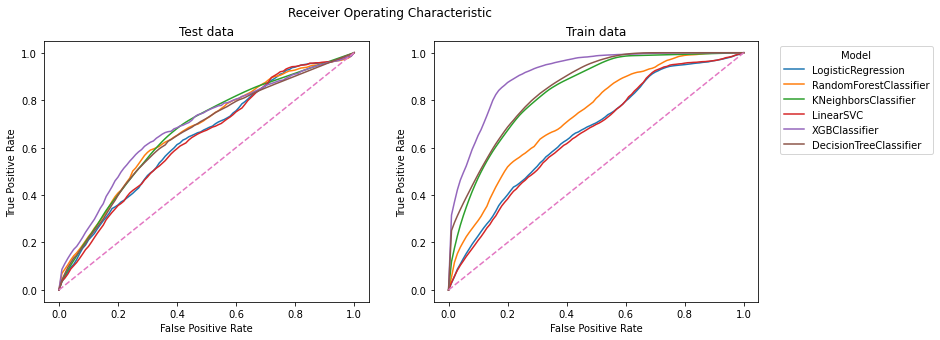

,test_f2,train_f2,test_geometric_mean,train_geometric_mean,test_roc_auc,train_roc_auc,model,test_mean,train_mean
0,0.505140,0.509663,0.601694,0.609309,0.636719,0.663827,LogisticRegression,0.553417,0.559486
1,0.510177,0.558015,0.609233,0.648026,0.667037,0.732358,RandomForestClassifier,0.559705,0.603020
2,0.482294,0.638856,0.623429,0.746832,0.669730,0.832847,KNeighborsClassifier,0.552861,0.692844
3,0.469089,0.487111,0.590196,0.607830,0.632003,0.658255,LinearSVC,0.529643,0.547471
4,0.494804,0.755736,0.643509,0.834845,0.685519,0.907865,XGBClassifier,0.569156,0.795290
5,0.506193,0.675946,0.624702,0.756707,0.655949,0.847692,DecisionTreeClassifier,0.565447,0.716326


In [142]:
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots(ncols=2, figsize=(12.8, 4.8))
# List of scores for the top models
scores_list = []

for model_name in model_list:
    scaler = StandardScaler()
    model = get_model_opt_by_name(model_name)
    model_scores = get_mean_scores(X, y, model, model_name, transformer, axis=ax)
    scores_list.append(model_scores)

    


columns = ['test_f2', 'train_f2', 'test_geometric_mean', 'train_geometric_mean', 
           'test_roc_auc', 'train_roc_auc', 'model']
test_metrics = ['test_f2', 'test_geometric_mean', 'test_roc_auc']
train_metrics = ['train_f2', 'train_geometric_mean', 'train_roc_auc']
top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics[:-1]].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics[:-1]].mean(axis=1)




ax[0].set(title='Test data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[0].plot([0,1], [0,1], linestyle='--')
ax[1].set(title='Train data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[1].plot([0,1], [0,1], linestyle='--')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Model', bbox_to_anchor=(1.05, 1))
plt.suptitle('Receiver Operating Characteristic')
plt.savefig('figures/roc_curve_KFold.png',  bbox_inches='tight', dpi=128)
plt.show()

top_scores

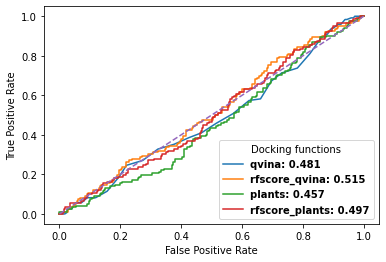

In [27]:
from sklearn.metrics import roc_curve, auc

# Plotting ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data[activity_label].values, data[SF].values)
    plt.plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')
    
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
font_prop = {'weight':'bold'}
plt.legend(title='Docking functions', loc='lower right', prop=font_prop)
plt.savefig('figures/docking_roc_curve.png', dpi=128)

<a id='supplementary'></a>
## Supplementary data

<a id='saving'></a>
### Saving the top 3 models

In [7]:
def save_pickle(model_fitted, model_name):
    # Serialize model
    import pickle
    with open(f'../pickle/{model_name}.pickle', 'wb') as file:
        pickle.dump(model_fitted, file)
        
def save_pipeline(model, descriptors_list, transformer, data, activity_label):
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import make_pipeline
    
    y_train = data[activity_label]
    X_train = data[descriptors_list]
    
    pipe = make_pipeline(SMOTE(random_state=42), transformer, model)    
    
    pipe.fit(X_train, y_train)
    save_pickle(pipe, model_name)

In [8]:
for model_name in ['RandomForestClassifier','KNeighborsClassifier','XGBClassifier']:
    model = get_model_opt_by_name(model_name)
    save_pipeline(model, descriptors_list, transformer, data, activity_label)